# Introduction

The goal of this project is to build a **multi-class text classification model** that can predict the programming language tag of a Stack Overflow question. The dataset contains programming questions labeled with one of four tags:

- Python
- Java
- JavaScript
- CSharp

To make the classification task more challenging, occurrences of language names in the question body have been replaced with the word `blank`. The objective is to predict the correct tag based on the content of each question.



In [39]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [40]:
print(tf.__version__)

2.18.0


## Data Preprocessing

Stack Overflow dataset containing programming questions is downloaded and extracted a curated labeled with one of four tags: **Python**, **Java**, **JavaScript**, or **CSharp**. Each label corresponds to the topic of the question. The dataset is organized into separate folders for training and testing.

In [43]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                  untar=True, cache_dir='.', cache_subdir='')

dataset_dir = dataset

In [44]:
os.listdir(dataset_dir)

['train', 'test', 'README.md']

In [45]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'python', 'javascript']

In [46]:
# View a sample Stack Overflow question from the "python" category
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

### Load the dataset



In [47]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,                      # this points to stack_overflow_16k/train
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [48]:
# Define label-to-class mapping (based on alphabetical folder order)
class_names = raw_train_ds.class_names
print("Class names:", class_names)

# Preview a few sample questions and their labels
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question:", text_batch.numpy()[i].decode('utf-8'))
        print("Label:", class_names[label_batch.numpy()[i]])
        print("---")

Class names: ['csharp', 'java', 'javascript', 'python']
Question: "my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and u

In [49]:
for i, class_name in enumerate(raw_train_ds.class_names):
    print(f"Label {i} corresponds to '{class_name}'")

Label 0 corresponds to 'csharp'
Label 1 corresponds to 'java'
Label 2 corresponds to 'javascript'
Label 3 corresponds to 'python'


In [50]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,                     # stack_overflow_16k/train
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [51]:
test_dir = os.path.join(dataset_dir, 'test')

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

We'll use the `TextVectorization` layer to preprocess the question texts. This layer will standardize, tokenize, and convert the raw text into integer sequences, making it suitable for input to the neural network. The default settings—lowercasing and punctuation removal—are sufficient for this dataset.

In [52]:
from tensorflow.keras.layers import TextVectorization

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [53]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [54]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [55]:
# Retrieve a batch (of 32 questions and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_question, first_label = text_batch[0], label_batch[0]

print("Question:", first_question.numpy().decode('utf-8'))
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized Question:", vectorize_text(first_question, first_label)[0].numpy())

Question: "unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can't know that the error is deriving because of setter or getter."

Label: java
Vectorized Question: [[1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
   196   12   74   13   72   33    2   98  105   14    3   70 9611    3
    34  888  202  773  107    8   41  242   40   58  291   90    3  196
   191   10    2  182    6  668    6   13   30 1187   12  773   22   42
     1   28    5  140   29 5213   15   29    1   28   51    1    1    1
  

In [56]:
# Preview a few tokens from the vocabulary
print("Token 1287 -->", vectorize_layer.get_vocabulary()[1287])
print("Token 313  -->", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

Token 1287 --> scissors
Token 313  --> source
Vocabulary size: 10000


In [57]:
# Apply the TextVectorization layer to all datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds   = raw_val_ds.map(vectorize_text)
test_ds  = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

To ensure smooth and efficient training, we apply `.cache()` and `.prefetch()` to the training, validation, and test datasets.

- `.cache()` stores the preprocessed data in memory (or on disk), reducing I/O overhead during training.
- `.prefetch()` overlaps data preprocessing and model execution, improving throughput.

These steps help accelerate training by reducing data loading bottlenecks.

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Implementation

The model is a simple text classification architecture built using the Keras Sequential API. It includes the following layers:

- **Embedding Layer:** Converts each word index into a dense vector representation, allowing the model to learn word relationships.
- **Dropout Layers:** Help prevent overfitting by randomly setting a fraction of the input units to zero during training.
- **GlobalAveragePooling1D:** Reduces the sequence of word embeddings into a single fixed-length vector by averaging.
- **Dense Output Layer (4 units):** Outputs one logit for each of the four possible tags: Python, Java, JavaScript, and CSharp.

This setup is lightweight and effective for a text classification task involving short programming questions.


### Create the model

In [60]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)  # 4 classes, no activation because we'll use from_logits=True
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

The model is built using a sequence of layers:

1. The first layer is an `Embedding` layer, which transforms each integer-encoded word into a dense vector representation. These vectors are learned during training.

2. A `GlobalAveragePooling1D` layer follows, which reduces the variable-length sequence of word embeddings into a fixed-length representation by averaging over the sequence.

3. The final layer is a `Dense(4)` layer, which outputs logits for four classes—corresponding to the programming language tags: Python, Java, JavaScript, and CSharp.

### Loss function and optimizer

Since this is a **multi-class classification** task with integer-labeled classes, we use the `SparseCategoricalCrossentropy` loss function with `from_logits=True`. The model will be compiled with this loss and the Adam optimizer.

In [61]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

### Train the model


In [62]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3081 - loss: 1.3789 - val_accuracy: 0.3413 - val_loss: 1.3559
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4119 - loss: 1.3395 - val_accuracy: 0.4325 - val_loss: 1.2967
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5012 - loss: 1.2722 - val_accuracy: 0.5481 - val_loss: 1.2124
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5761 - loss: 1.1870 - val_accuracy: 0.5906 - val_loss: 1.1291
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6188 - loss: 1.1042 - val_accuracy: 0.6794 - val_loss: 1.0445
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6607 - loss: 1.0261 - val_accuracy: 0.6938 - val_loss: 0.9735
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6889 - loss: 0.9596 - val_accuracy: 0.7050 - val_loss: 0.9113
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7038 - loss: 0.8996 - val_accuracy: 0.

## Model Evaluation

Accuracy here reflects the percentage of Stack Overflow questions where the predicted tag matches the true label.

In [63]:
loss, accuracy = model.evaluate(test_ds)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7138 - loss: 0.8133
Test Loss: 0.8133983016014099
Test Accuracy: 0.7122499942779541


### Create a plot of accuracy and loss over time

The `model.fit()` function returns a `History` object that stores the training process details, including the values of loss and accuracy for each epoch on both the training and validation sets.

In [64]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Visualization and Analysis

This section presents visualizations of training and validation metrics over time, including loss and accuracy. These plots help assess model learning trends, identify potential issues like overfitting or underfitting, and guide decisions such as early stopping. By comparing training and validation curves, we can better understand how the model performs during learning and how well it generalizes to unseen data.

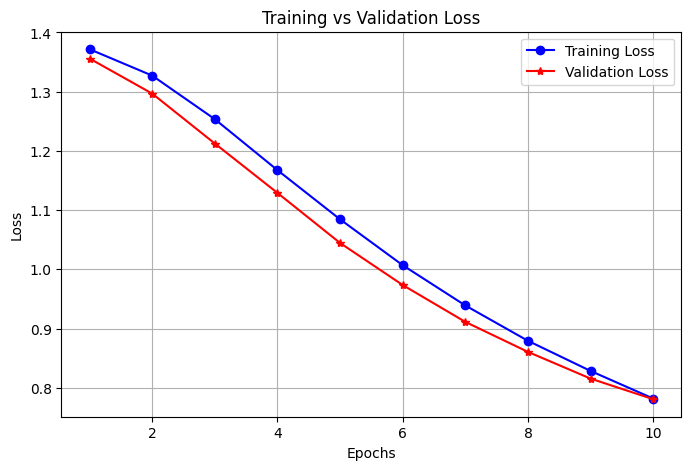

In [68]:
# Extract metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

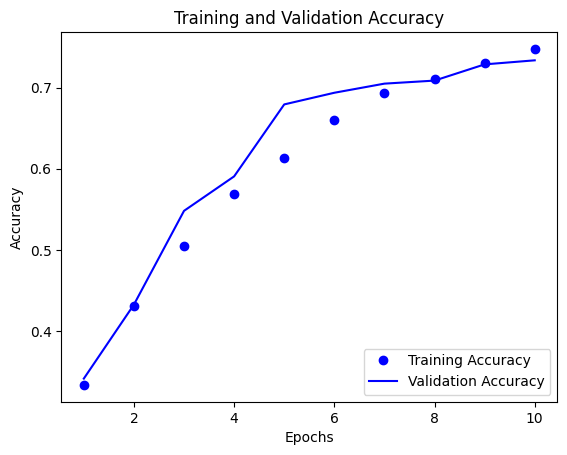

In [66]:
# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Training Insights

In the first graph, both the training and validation loss steadily decrease over all 10 epochs. This suggests that the model is learning consistently and not overfitting — at least not within this training window.

In the second graph, we see that training accuracy increases steadily, and validation accuracy follows a very similar trend. While training accuracy is slightly higher (as expected), the gap between training and validation accuracy is small, which means the model is generalizing well.

Overall, there is no major sign of overfitting in this case. The model continues to improve on both training and unseen validation data, and performance appears stable through all 10 epochs.

## Conclusion

We built and trained a multi-class text classification model to predict programming tags from Stack Overflow questions. The model showed steady improvements in both training and validation accuracy, with no major signs of overfitting. Overall, it performs well on unseen data and provides a solid baseline for future enhancements.
